# Uncertainty analyses

The purpose of this notebook is to assess the uncertainty on various climate metrics due to uncertainty in input climate settings relative to aviation species (sensitivity to emissions, ERF/RF, efficacy). The calculations (Monte Carlo experiments) leverage the Python library [SALib](https://salib.readthedocs.io/en/latest/), which could be used in future work to run sensitivity analyses.

Note that the uncertainty analyses a ran using the surrogate models instead of the full climate models.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from aerometrics.paper.functions.metric_functions import gwp_rf_contrails, egwp_contrails

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

## 1. Wrap metrics calculation in function

In [112]:
def climate_metric_parametric(
    metric: str,
    time_horizon_range: np.ndarray,
    sensitivity_rf: float,
    ratio_erf_rf: float,
    efficacy_erf: float
):
    """Compute climate metrics (GWP_RF or EGWP_ERF) over a time horizon."""
    
    if metric == 'gwp_rf':
        return np.array([
            gwp_rf_contrails(t, sensitivity_rf, ratio_erf_rf, efficacy_erf)
            for t in time_horizon_range
        ])

    elif metric == 'egwp_erf':
        return np.array([
            egwp_contrails(t, sensitivity_rf, ratio_erf_rf, efficacy_erf)
            for t in time_horizon_range
        ])

    else:
        raise ValueError(f"Unknown metric: {metric}")

## 2. Uncertainty analysis

### a) Define uncertain inputs

In [113]:
# Define uncertain inputs
sp_metrics = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf', 'model_error'],
    'bounds': [
        [2.23e-12, 7.96e-13],  # (mean, std)
        [0.23, 0.87],  # [min, max]
        [0.12, 0.64],  # [min, max]
        [0.00023, 0.0214],  # (mean, std) # obtained from surrogate_models notebook
    ],
    'dists': ['norm', 'unif', 'unif', 'norm'],
})

### b) Run analysis

In [114]:
METRICS = ['gwp_rf', 'egwp_erf']
TIME_HORIZON_RANGE = np.arange(15, 110, 5)

def run_sensitivity(sp, metric, nb_samples, time_horizon_range=TIME_HORIZON_RANGE):
    """Run Sobol sampling, evaluation, and analysis for a given metric."""
    (
        sp.sample_sobol(nb_samples, calc_second_order=False)
          .evaluate(lambda params: np.array([
              climate_metric_parametric(metric, time_horizon_range, *p[:-1])  # input parameters uncertainty
              * (1 + p[-1])  # model uncertainty
              for p in params
          ]))
          .analyze_sobol(calc_second_order=False)
    )
    return sp.results

# Initialize results array
y_results = np.zeros((11, 4))

# Run uncertainty analysis for a range of Monte Carlo samples
for idx, k in enumerate(range(3, 14)):
    nb_samples = 2 ** k
    print("running Monte Carlo for nb_samples=", nb_samples)
    
    y1 = run_sensitivity(sp_metrics, METRICS[0], nb_samples)
    y2 = run_sensitivity(sp_metrics, METRICS[1], nb_samples)

    y_results[idx, 0:2] = [np.mean(y1, axis=0)[-1], np.std(y1, axis=0)[-1]]
    y_results[idx, 2:4] = [np.mean(y2, axis=0)[-1], np.std(y2, axis=0)[-1]]

running Monte Carlo for nb_samples= 8
running Monte Carlo for nb_samples= 16
running Monte Carlo for nb_samples= 32
running Monte Carlo for nb_samples= 64


/opt/miniconda3/envs/AeroMetrics/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


running Monte Carlo for nb_samples= 128
running Monte Carlo for nb_samples= 256
running Monte Carlo for nb_samples= 512
running Monte Carlo for nb_samples= 1024
running Monte Carlo for nb_samples= 2048
running Monte Carlo for nb_samples= 4096
running Monte Carlo for nb_samples= 8192


### c) Plot

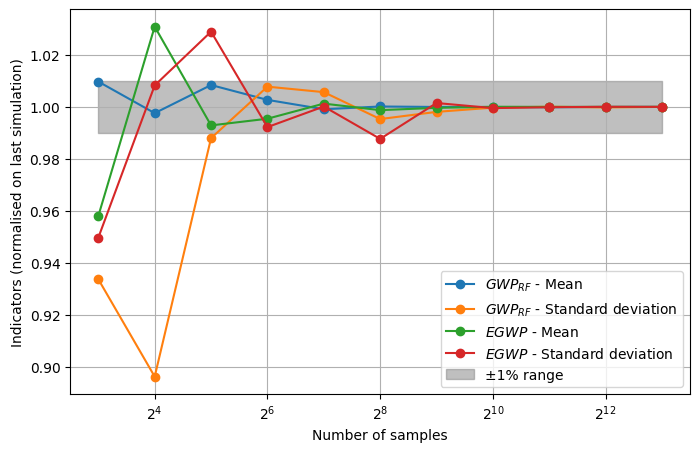

In [115]:
### Convergence of Monte Carlo simulations

plt.figure(figsize=(8, 5))
x = [2**i for i in range(3,14)]
plt.plot(x, y_results[:,0]/y_results[-1,0], marker='o', label=r"$GWP_{RF}$ - Mean")
plt.plot(x, y_results[:,1]/y_results[-1,1], marker='o', label=r"$GWP_{RF}$ - Standard deviation")
plt.plot(x, y_results[:,2]/y_results[-1,2], marker='o', label=r"$EGWP$ - Mean")
plt.plot(x, y_results[:,3]/y_results[-1,3], marker='o', label=r"$EGWP$ - Standard deviation")
plt.fill_between(x, 0.99*np.ones(len(y_results[:,0])), 1.01*np.ones(len(y_results[:,0])), alpha = 0.5, color='grey', label="±1% range")
plt.xscale('log', base=2)
plt.legend()

plt.xlabel('Number of samples')
plt.ylabel('Indicators (normalised on last simulation)')
plt.grid(True)

plt.show()

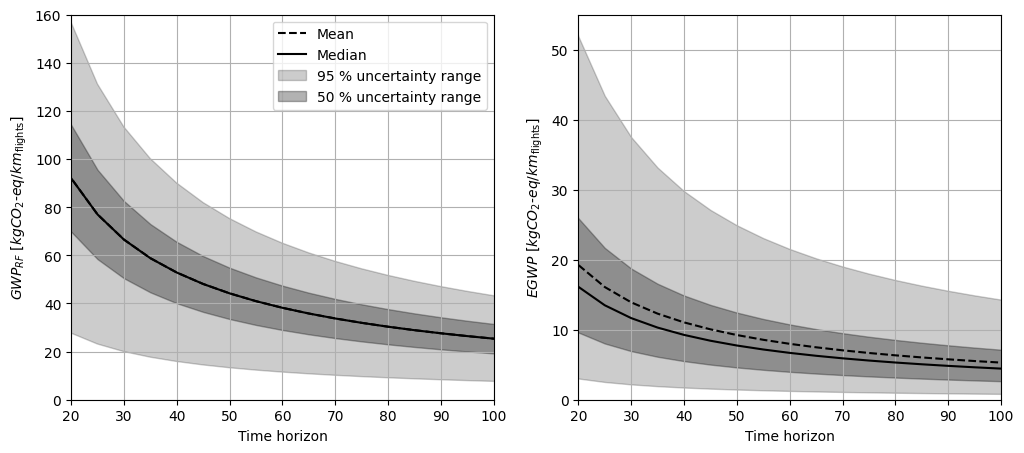

In [116]:
### Metrics with their uncertainty ranges

# Set up figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Fig 1
axs[0].plot(TIME_HORIZON_RANGE, np.mean(y1, axis=0), label=r"Mean", color='black', linestyle='--')
axs[0].plot(TIME_HORIZON_RANGE, np.median(y1, axis=0), label=r"Median", color='black')

prediction_interval = 95
axs[0].fill_between(TIME_HORIZON_RANGE,
                 np.percentile(y1, 50 - prediction_interval/2., axis=0),
                 np.percentile(y1, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % uncertainty range")

prediction_interval = 50
axs[0].fill_between(TIME_HORIZON_RANGE,
                 np.percentile(y1, 50 - prediction_interval/2., axis=0),
                 np.percentile(y1, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % uncertainty range")

axs[0].set_xlabel("Time horizon")
axs[0].set_xlim(20, 100)
axs[0].set_ylim(0, 160)
axs[0].set_ylabel(r'$GWP_{RF}$ [$kgCO_2\text{-}eq/km_{\text{flights}}$]')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Fig 2
axs[1].plot(TIME_HORIZON_RANGE, np.mean(y2, axis=0), label=r"Mean", color='black', linestyle='--')
axs[1].plot(TIME_HORIZON_RANGE, np.median(y2, axis=0), label=r"Median", color='black')

prediction_interval = 95
axs[1].fill_between(TIME_HORIZON_RANGE,
                 np.percentile(y2, 50 - prediction_interval/2., axis=0),
                 np.percentile(y2, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % uncertainty range")

prediction_interval = 50
axs[1].fill_between(TIME_HORIZON_RANGE,
                 np.percentile(y2, 50 - prediction_interval/2., axis=0),
                 np.percentile(y2, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % uncertainty range")

axs[1].set_xlabel("Time horizon")
axs[1].set_xlim(20, 100)
axs[1].set_ylim(0, 55)
axs[1].set_ylabel(r'$EGWP$ [$kgCO_2\text{-}eq/km_{\text{flights}}$]')
axs[1].grid(True)

plt.savefig("figures/metric_uncertainties.pdf")
plt.show()